This notebook aims at **testing the two-layer Arctic hypothesis**. We expected the surface current in the main Arctic (Canada Basin + Makarov Basin) goes in cyclonic way and anti-cyclonic in deeper layer.

Therefore, this notebook plots the surface layer and the salinity maximum layer to see whether the hypothesis is right or not. 

**Conclusion: The surface current is not going in a cyclonic way. Have to say this hypothesis is not right at the first place..:(. But the good news is that the simulated flow is very closed to the geostrophic pattern, which means 'geostrophic flow' might be the answer to our original question - why the flow goes in an anti-cyclonic way.**

In [1]:
import copy,os,glob
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
from ArcticTools import hovmoller as hov
from ArcticTools import geostropic as geo
% matplotlib inline

In [2]:
import importlib
importlib.reload(geo)

<module 'ArcticTools.geostropic' from '/ocean/xiaoxiny/research/tools/ArcticTools/geostropic.py'>

In [3]:
with nc.Dataset(sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/para60Run/result/ENG319582008.nc'))[0]) \
as ptrc:
    nav_lon = ptrc.variables['nav_lon'][:,:]
    nav_lat = ptrc.variables['nav_lat'][:,:]
    dep  =  ptrc.variables['deptht'][:]


tmask = nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
mbathy = tmask.variables['mbathy'][0,400:,:]
tmask = tmask.variables['tmask'][0,:,400:,:]


bathy = nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy = bathy.variables['Bathymetry'][400:,:]

In [4]:
uvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')
vvel = nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

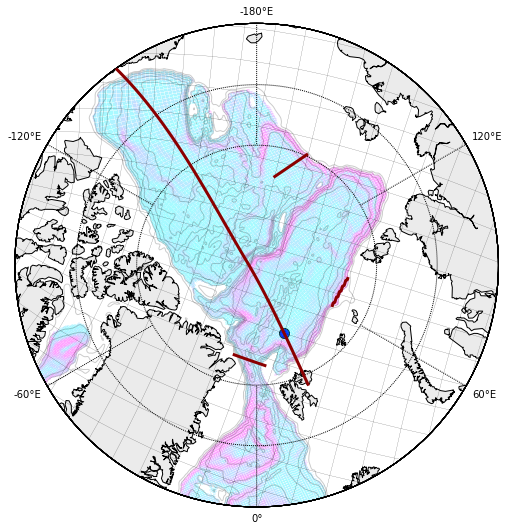

In [5]:
# test functions above
fig  =  plt.figure(figsize = (13/1.5,13/1.5))
ax  =  fig.add_subplot()
m,x_lon,y_lat = hov.mapping(70)

#sec1 Makarov
x_mb,y_mb,a_mb,b_mb = hov.section(x0 = -130,y0 = 300,length = 20,xi = 1,yi = 1, x_lon=x_lon, y_lat=y_lat)
m.plot(a_mb[:],b_mb[:],color = 'darkred',linewidth = 3)
#m.scatter(a_mb[15],b_mb[15],color = 'darkred',linewidth = 3)


#sec2 Nansen
x_ns,y_ns,a_ns,b_ns = hov.section(x0 = -210,y0 = 368,length = 25,xi = 1,yi = 0.2, x_lon=x_lon, y_lat=y_lat)
m.plot(a_ns[:],b_ns[:],color = 'darkred',linewidth = 3)
#m.scatter(a_ns[15],b_ns[15],color = 'darkred',linewidth = 3)


#sec3 CB
x_cb,y_cb,a_cb,b_cb = hov.section(x0 = 330,y0 = 170,length = 100,xi = -2,yi = 2, x_lon=x_lon, y_lat=y_lat)
m.plot(a_cb[:],b_cb[:],color = 'darkred',linewidth = 3)
m.scatter(a_cb[-15],b_cb[-15], s=100)


#sec4 Fram strait 
x_fs,y_fs,a_fs,b_fs = hov.section(x0 = -265,y0 = 310,length =25 ,xi = 0 ,yi = 1, x_lon=x_lon, y_lat=y_lat)
m.plot(a_fs[:],b_fs[:],color = 'darkred',linewidth = 3)
#m.scatter(a_fs[15],b_fs[15],color = 'darkred',linewidth = 3)

# plot one velocity snapshot, make sure my profile is not far away from the pathway
data  = (uvel.variables['vozocrtx'][5,35,400:,:]**2 + vvel.variables['vomecrty'][5,35,400:,:]**2)**0.5
m.pcolor(x_lon,y_lat,data[:,:],cmap = 'cool',vmax = 0.04, alpha = 0.1)

In [6]:
def section_hovmoller(indexa,indexb,data,layer,tmask, nav_lon):
    '''load data for vertical profiles, return to tracer/cooridination 
     ================================================================
     
    arg:  data: 4-dimension model result from NEMO model 
    type: data: np.array
    
    arg:  layer: for a desired depth of the field
    type: layer: interger
    
    arg:  length: length of the section  (Longer the section, bigger this number)
    type: length: interger   
    
    arg:  x0, y0: the starting point of the section.  
    type: x0, y0: interger

    arg:  xi, yi: slope  example: xi  =  0.5 then x0 + 0.5 * i
    type: xi, yi: floats/interger 
                 (If choose floats, index could be floats as well but it will Round to nearest integer)

    '''
    temp = np.zeros((data.shape[0],layer, len(indexa)))
    for i in range (layer):
        temp[:,i,...] = data[:,i,indexa,indexb]
        for k in range (data.shape[0]):
            temp[k,i,...][tmask[i,indexa,indexb] == 0] = np.nan

    coordinate = nav_lon[indexa,indexb]
    return temp,coordinate


def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
    #data  = np.ma.masked_where(tmask == 0,data)
    return data

# s & T at the scatter point

In [7]:
# preprae data -- t
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('T',T=i+2002,tmask= tmask, ENG='exh001', key = '_t_')
    Temp[i,...]=data
    
temp,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=45,tmask=tmask, nav_lon=nav_lon)


# preprae data -- s
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= hov.load_ts('S',T=i+2002,tmask= tmask, ENG='exh001', key = '_s_')
    Temp[i,...]=data
salinity,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=45,tmask=tmask, nav_lon=nav_lon)


# preprae data -- u
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= load_v('U',T=i+2002,tmask= tmask, ENG='EXH001', key = 'U')
    Temp[i,...]=data
    
u,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=45,tmask=tmask, nav_lon=nav_lon)

# preprae data -- v
Temp = np.zeros((2014-2002,50,nav_lon.shape[0],nav_lon.shape[1]))
for i in range (2014-2002):
    data= load_v('V',T=i+2002,tmask= tmask, ENG='EXH001', key = 'V')
    Temp[i,...]=data
v,coor = section_hovmoller(indexa=x_cb,indexb=y_cb,data=Temp,layer=45,tmask=tmask, nav_lon=nav_lon)



Take a  look at the vertical profile at the scatter point:

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


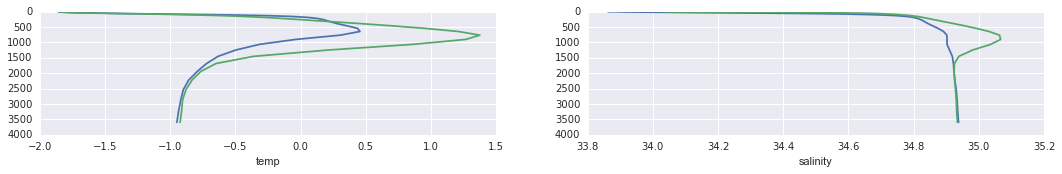

In [8]:
import seaborn as sns
fig  =  plt.figure(figsize = (18,9/1.2))
ax = plt.subplot(3,2,1)
for i in [0,-1]:
    plt.plot(np.ma.masked_invalid(temp[i,:45.,-15]),dep[:45]) #[0,...] means 
plt.gca().invert_yaxis()
plt.xlabel('temp')

ax = plt.subplot(3,2,2)
for i in [0,-1]:
    plt.plot(np.ma.masked_invalid(salinity[i,:45.,-15]),dep[:45])
plt.gca().invert_yaxis()
plt.xlabel('salinity')

In [30]:
print ('temp maximum: layer %s, depth %s'%(temp[-1,:45.,-15].argmax(),dep[temp[-1,:45.,-15].argmax()]))
print ('salinity maximum: layer %s, depth %s'%(salinity[-1,:45.,-15].argmax(),dep[salinity[-1,:45.,-15].argmax()]))

temp maximum: layer 33, depth 763.333
salinity maximum: layer 34, depth 902.339


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


Trying to see what the u and v look like in temp maiximum layer

In [10]:
# grid for plotting
x1d=np.linspace(0,nav_lon[:,0].shape[0],nav_lat[:,0].shape[0])
y1d=np.linspace(0,nav_lon[0,:].shape[0],nav_lat[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

# cyclonic year (2002) & anti-cyclonic(2014)  -- salinity maximum layer


> green arrows are goestrophic flow/ black arrows are flows from model. (They have the same scale.)

> the background contour plot is the pressure.  (At the left hand side, the lower one is an averaged temperature plot. The temperature profiles are averaged from surface to this salinity maximum layer. The upper one is an averaged salinity plot. Again, averaged from surface to the current layer.)

In [11]:
# assign layer
layer= salinity[-1,:45.,-15].argmax()
layer

/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


34

Plot salinity maximum layer with modeled velocity
year :2002


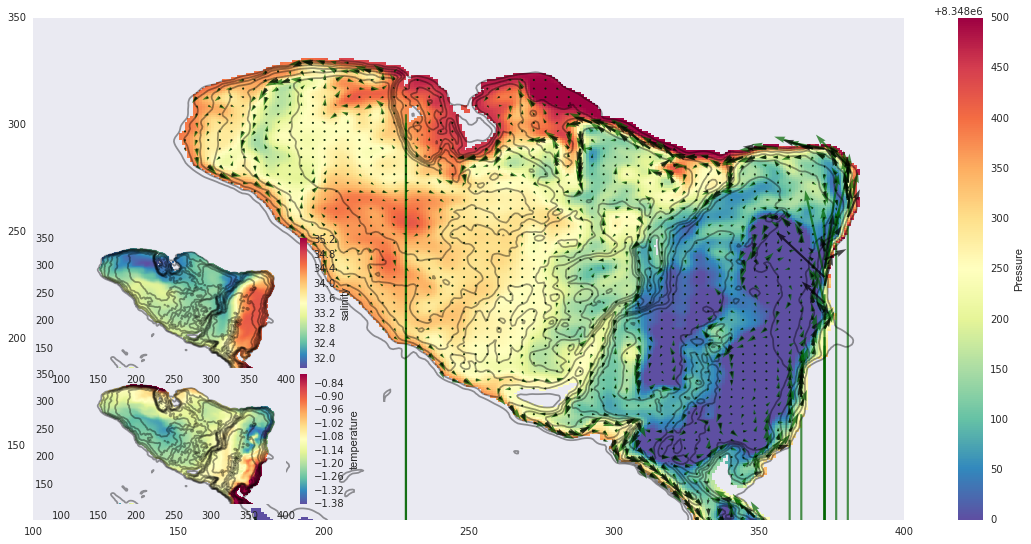

year :2014


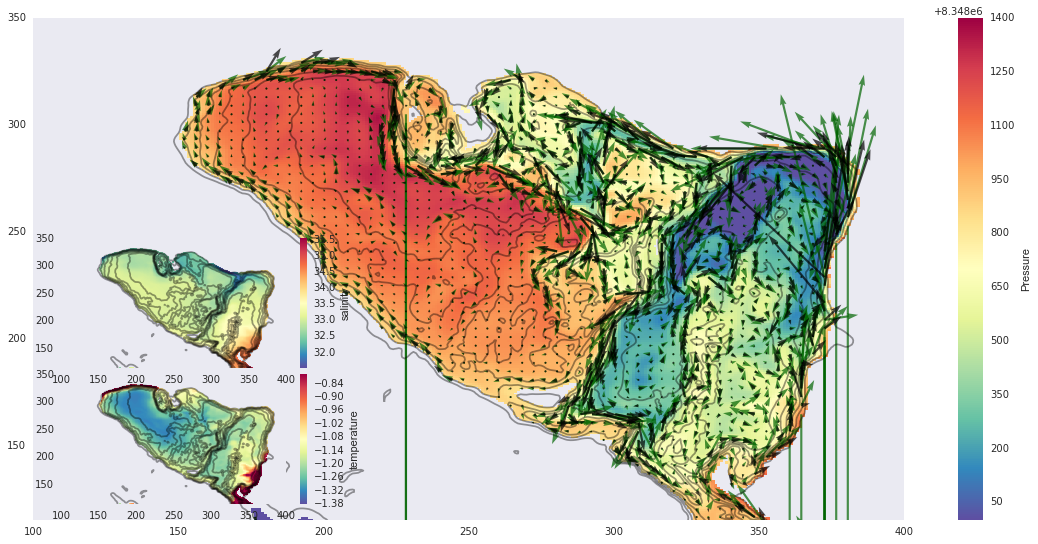

In [20]:
print ('Plot salinity maximum layer with modeled velocity')

T=2002

for year,vmin,vmax in zip ([2002,2014],[8.347e6+1000,8.347e6+1000],[8.347e6+1500,8.347e6+2400]):
    print ("year :%s"%year)
    ug_0,vg_0,P_0,nav_lat,nav_lon = geo.geoflow(\
        modelt=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_t_year%s.nc'%year),
        models=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_s_year%s.nc'%year),
        modelssh=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%year),
        layer=layer,ssh_key = 'True',detail = 'False')


    fig = plt.figure(figsize=(13*1.5,6*1.5))    

    plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_0),cmap='Spectral_r',
               vmin=vmin,vmax=vmax)
                #vmin=np.ma.masked_invalid(P_0[:,:]).min()+3800, vmax=np.ma.masked_invalid(P_0[:,:]).max()-100);
    cbar=plt.colorbar()
    cbar.set_label('Pressure')
    #vector
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.ma.masked_invalid(ug_0[::4,::4]), np.ma.masked_invalid(vg_0[::4,::4]),
               scale=2.,width=0.0025,color='darkgreen',alpha=0.7)

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], u[layer,::4,::4], v[layer,::4,::4],
               scale=2.,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)



    left, bottom, width, height = [0.145, 0.15, 0.2, 0.2]
    ax = fig.add_axes([left, bottom, width, height])
    data= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    data = np.sum(data[:layer,:,:],axis=0)
    data = np.ma.masked_where(tmask[layer,:,:]==0,data)
    im=ax.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer),cmap='Spectral_r',vmin=-1.38,vmax=-0.8);
    cbar=fig.colorbar(im, ax=ax)
    cbar.set_label('temperature')
    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    ;plt.xlim(100,400)


    left, bottom, width, height = [0.145, 0.36, 0.2, 0.2]
    ax = fig.add_axes([left, bottom, width, height])
    data= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')
    data = np.sum(data[:layer,:,:],axis=0)
    data = np.ma.masked_where(tmask[layer,:,:]==0,data)
    im=ax.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer),cmap='Spectral_r');
    cbar=fig.colorbar(im, ax=ax)
    cbar.set_label('salinity')
    plt.ylim(115,350);plt.xlim(100,400)
    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.show()

* The change from red rim (at canada side) to yellow rim is the reason that caused the change from cyclonic to anti-cyclonic. During all this time, the surface layer stays at anti-cyclonic pattern and it even gets stronger in latter year, which is conflict to our hypothesis.


# cyclonic  year / anti-cyclonic year  -- surface

> green arrows are goestrophic flow/ black arrows are flows from model.

> the background contour plot is the pressure.

In [21]:
print ('Plot surface cool layer with modeled velocity')
layer = salinity[0,:45.,-15].argmin()+1

Plot surface cool layer with modeled velocity


/home/xiaoxiny/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


year :2002


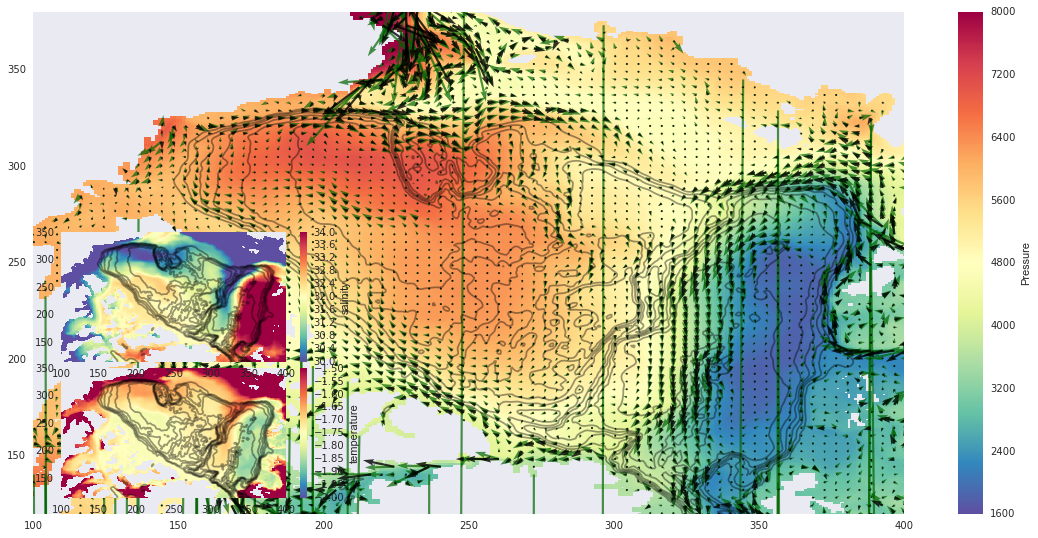

year :2014


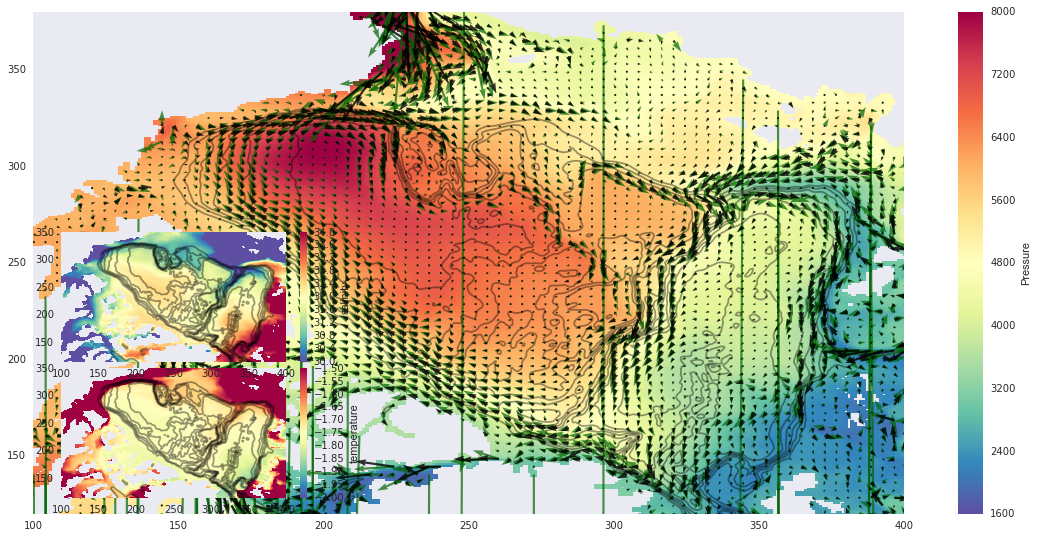

In [27]:
for year,vmin,vmax in zip ([2002,2014],[1600,1600],[8000,8000]):
    print ("year :%s"%year)
    ug_0,vg_0,P_0,nav_lat,nav_lon = geo.geoflow(\
        modelt=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_t_year%s.nc'%year),
        models=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_s_year%s.nc'%year),
        modelssh=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_exh001/ANHA4-EXH001_gridT_ssh_year%s.nc'%year),
        layer=layer,ssh_key = 'True',detail = 'False')

    fig = plt.figure(figsize=(13*1.5,6*1.5))    
    data= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    plt.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(P_0[:,:]),cmap='Spectral_r',\
               vmin=vmin, vmax=vmax);
    cbar=plt.colorbar()
    cbar.set_label('Pressure')

    #vector
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.ma.masked_invalid(ug_0[::4,::4]), np.ma.masked_invalid(vg_0[::4,::4]),
               scale=5.,width=0.0025,color='darkgreen',alpha=0.7)

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], u[layer,::4,::4], v[layer,::4,::4],
               scale=5.,width=0.0025,color='k',alpha=0.8)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})
    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(120,380)    
    plt.xlim(100,400)
    
    
    left, bottom, width, height = [0.145, 0.15, 0.2, 0.2]
    ax = fig.add_axes([left, bottom, width, height])
    data= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    data = np.sum(data[:layer,:,:],axis=0)
    data = np.ma.masked_where(tmask[layer,:,:]==0,data)
    im=ax.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer),cmap='Spectral_r',vmin=-2,vmax=-1.5);
    cbar=fig.colorbar(im, ax=ax)
    cbar.set_label('temperature')
    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    ;plt.xlim(100,400)


    left, bottom, width, height = [0.145, 0.36, 0.2, 0.2]
    ax = fig.add_axes([left, bottom, width, height])
    data= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')
    data = np.sum(data[:layer,:,:],axis=0)
    data = np.ma.masked_where(tmask[layer,:,:]==0,data)
    im=ax.pcolor(x2d[:,:], y2d[:,:], np.ma.masked_invalid(data[:,:]/layer),cmap='Spectral_r',vmin=30,vmax=34);
    cbar=fig.colorbar(im, ax=ax)
    cbar.set_label('salinity')
    plt.ylim(115,350);plt.xlim(100,400)
    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.show()
    
    
    plt.show()

looks like temperature is more dominant in density.. (because the salinity seems to have a negative relationship with density but we know this is not true.)


In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
